# Seleção de Modelos - Classificação de Spam

## Problema

Classificar emails como spam ou ham (legítimo) baseado no conteúdo textual.

Este é um problema de **CLASSIFICAÇÃO BINÁRIA SUPERVISIONADA**, onde vamos usar features de texto (TF-IDF) para prever a classe.

## Modelos a Testar

1. **Multinomial Naive Bayes** - Baseline clássico para NLP
2. **Logistic Regression** - Modelo linear robusto
3. **SVM (Support Vector Machine)** - Boa performance em texto
4. **Random Forest** - Ensemble, robusto
5. **XGBoost** - Gradient boosting de alta performance

## Pipeline

1. Carregar dados processados do notebook 01
2. Treinar todos os modelos
3. Comparar métricas (Accuracy, Precision, Recall, F1-Score)
4. Selecionar melhor modelo
5. Hyperparameter tuning no melhor modelo (próximo notebook)
6. Exportar modelo final (notebook 04)

## Dataset

Utilizando os dados já processados do notebook de análise exploratória:
- 66,758 emails de treino
- 16,690 emails de teste
- Features: TF-IDF (5000 features)


In [4]:
# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from pathlib import Path
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Modelos de Classificação
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Configurações de visualização
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 6)
sns.set_palette("husl")

print("Bibliotecas carregadas com sucesso")


Bibliotecas carregadas com sucesso


## Passo 1: Carregamento de Dados Processados

Carregar os dados já processados e vetorizados do notebook 01.


In [5]:
# Carregar data splits do notebook 01
splits_path = Path('artifacts/data_splits.joblib')

if not splits_path.exists():
    raise FileNotFoundError(
        "Artefatos do notebook 01 não encontrados. "
        "Execute primeiro o notebook 01_exploratory_analysis.ipynb"
    )

data_splits = joblib.load(splits_path)

# Extrair dados vetorizados
X_train_tfidf = data_splits['X_train_tfidf']
X_test_tfidf = data_splits['X_test_tfidf']
y_train = data_splits['y_train']
y_test = data_splits['y_test']

print("Dados carregados com sucesso!")
print(f"\nShape dos dados:")
print(f"X_train_tfidf: {X_train_tfidf.shape}")
print(f"X_test_tfidf: {X_test_tfidf.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Verificar distribuição das classes
print(f"\nDistribuição das classes (treino):")
print(y_train.value_counts())
print(f"\nDistribuição das classes (teste):")
print(y_test.value_counts())


Dados carregados com sucesso!

Shape dos dados:
X_train_tfidf: (66758, 5000)
X_test_tfidf: (16690, 5000)
y_train: (66758,)
y_test: (16690,)

Distribuição das classes (treino):
label
spam    35128
ham     31630
Name: count, dtype: int64

Distribuição das classes (teste):
label
spam    8782
ham     7908
Name: count, dtype: int64


In [ ]:
# Converter labels para numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Mapeamento para referência
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Mapeamento de labels: {label_mapping}")
print(f"Ham = {label_mapping.get('ham', 'N/A')}, Spam = {label_mapping.get('spam', 'N/A')}\n")

# Dicionário de modelos
# Nota: XGBoost usa labels numéricos, outros usam strings
# LinearSVC é muito mais rápido que SVC para problemas lineares
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=1, verbosity=0),
    'SVM (LinearSVC)': LinearSVC(random_state=42, max_iter=2000, dual=False)
}

# Dicionário para armazenar resultados
results = {}

print("Treinando modelos...\n")
print("=" * 70)

for name, model in models.items():
    print(f"\nTreinando {name}...")
    
    # Medir tempo
    start_time = time.time()
    
    try:
        # XGBoost precisa de labels numéricos
        if 'XGBoost' in name:
            y_train_model = y_train_encoded
        else:
            y_train_model = y_train
        
        # Treinar
        model.fit(X_train_tfidf, y_train_model)
        
        # Calcular tempo
        train_time = time.time() - start_time
        
        # Armazenar
        results[name] = {
            'model': model,
            'train_time': train_time
        }
        
        print(f"  Tempo de treinamento: {train_time:.2f}s")
        print(f"  ✓ {name} treinado com sucesso!")
        
    except Exception as e:
        train_time = time.time() - start_time
        print(f"  ✗ ERRO ao treinar {name}: {str(e)}")
        print(f"  Tempo decorrido: {train_time:.2f}s")
        print(f"  Pulando este modelo...")
        continue

print("\n" + "=" * 70)
print(f"Modelos treinados com sucesso: {len(results)}/{len(models)}")
print("=" * 70)


Mapeamento de labels: {'ham': np.int64(0), 'spam': np.int64(1)}
Ham = 0, Spam = 1

Treinando modelos...


Treinando Multinomial Naive Bayes...
  Tempo de treinamento: 0.10s
  ✓ Multinomial Naive Bayes treinado com sucesso!

Treinando Logistic Regression...
  Tempo de treinamento: 0.31s
  ✓ Logistic Regression treinado com sucesso!

Treinando Random Forest...
  Tempo de treinamento: 104.23s
  ✓ Random Forest treinado com sucesso!

Treinando XGBoost...
  Tempo de treinamento: 73.70s
  ✓ XGBoost treinado com sucesso!

Treinando SVM (LinearSVC)...
  Tempo de treinamento: 1.32s
  ✓ SVM (LinearSVC) treinado com sucesso!

Modelos treinados com sucesso: 5/5


## Passo 3: Avaliação de Performance

Calcular métricas de precisão (Accuracy, Precision, Recall, F1-Score) para cada modelo no test set.

### Métricas Explicadas:
- **Accuracy**: Percentual de predições corretas
- **Precision**: Dos preditos como spam, quantos são realmente spam
- **Recall**: Dos spams reais, quantos foram detectados
- **F1-Score**: Média harmônica de Precision e Recall (melhor métrica balanceada)


In [8]:
# Avaliar cada modelo
print("MÉTRICAS DE PERFORMANCE\n")
print("=" * 80)

for name, data in results.items():
    model = data['model']
    
    # Fazer predições no test set
    y_pred = model.predict(X_test_tfidf)
    
    # XGBoost retorna labels numéricos, precisa converter de volta
    if 'XGBoost' in name:
        y_pred = label_encoder.inverse_transform(y_pred)
    
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='spam', zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label='spam', zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label='spam', zero_division=0)
    
    # Armazenar métricas
    results[name]['accuracy'] = accuracy
    results[name]['precision'] = precision
    results[name]['recall'] = recall
    results[name]['f1'] = f1
    
    print(f"{name}:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    print(f"  Tempo:     {data['train_time']:.2f}s")
    print()

print("=" * 80)


MÉTRICAS DE PERFORMANCE

Multinomial Naive Bayes:
  Accuracy:  0.9661 (96.61%)
  Precision: 0.9697 (96.97%)
  Recall:    0.9657 (96.57%)
  F1-Score:  0.9677 (96.77%)
  Tempo:     0.10s

Logistic Regression:
  Accuracy:  0.9827 (98.27%)
  Precision: 0.9804 (98.04%)
  Recall:    0.9869 (98.69%)
  F1-Score:  0.9837 (98.37%)
  Tempo:     0.31s

Random Forest:
  Accuracy:  0.9849 (98.49%)
  Precision: 0.9847 (98.47%)
  Recall:    0.9867 (98.67%)
  F1-Score:  0.9857 (98.57%)
  Tempo:     104.23s

XGBoost:
  Accuracy:  0.9787 (97.87%)
  Precision: 0.9694 (96.94%)
  Recall:    0.9908 (99.08%)
  F1-Score:  0.9800 (98.00%)
  Tempo:     73.70s

SVM (LinearSVC):
  Accuracy:  0.9857 (98.57%)
  Precision: 0.9830 (98.30%)
  Recall:    0.9900 (99.00%)
  F1-Score:  0.9865 (98.65%)
  Tempo:     1.32s



## Passo 4: Comparação de Modelos

Tabela comparativa com todas as métricas.


In [9]:
# Criar DataFrame comparativo
comparison_data = []

for name, data in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': data['accuracy'],
        'Precision': data['precision'],
        'Recall': data['recall'],
        'F1-Score': data['f1'],
        'Train Time (s)': data['train_time']
    })

comparison_df = pd.DataFrame(comparison_data)

# Ordenar por F1-Score (melhor métrica balanceada)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("TABELA COMPARATIVA DE MODELOS\n")
print(comparison_df.to_string(index=False))

# Identificar melhor modelo
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']
best_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"\n{'='*80}")
print(f"MELHOR MODELO: {best_model_name}")
print(f"  F1-Score:  {best_f1:.4f} ({best_f1*100:.2f}%)")
print(f"  Accuracy:  {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"{'='*80}")


TABELA COMPARATIVA DE MODELOS

                  Model  Accuracy  Precision   Recall  F1-Score  Train Time (s)
        SVM (LinearSVC)  0.985740   0.983039 0.989980  0.986497        1.321981
          Random Forest  0.984901   0.984659 0.986677  0.985667      104.227795
    Logistic Regression  0.982744   0.980430 0.986905  0.983657        0.308208
                XGBoost  0.978670   0.969363 0.990777  0.979953       73.702738
Multinomial Naive Bayes  0.966087   0.969700 0.965725  0.967709        0.104386

MELHOR MODELO: SVM (LinearSVC)
  F1-Score:  0.9865 (98.65%)
  Accuracy:  0.9857 (98.57%)


## Passo 5: Visualização das Métricas

Gráficos comparativos das métricas de cada modelo.


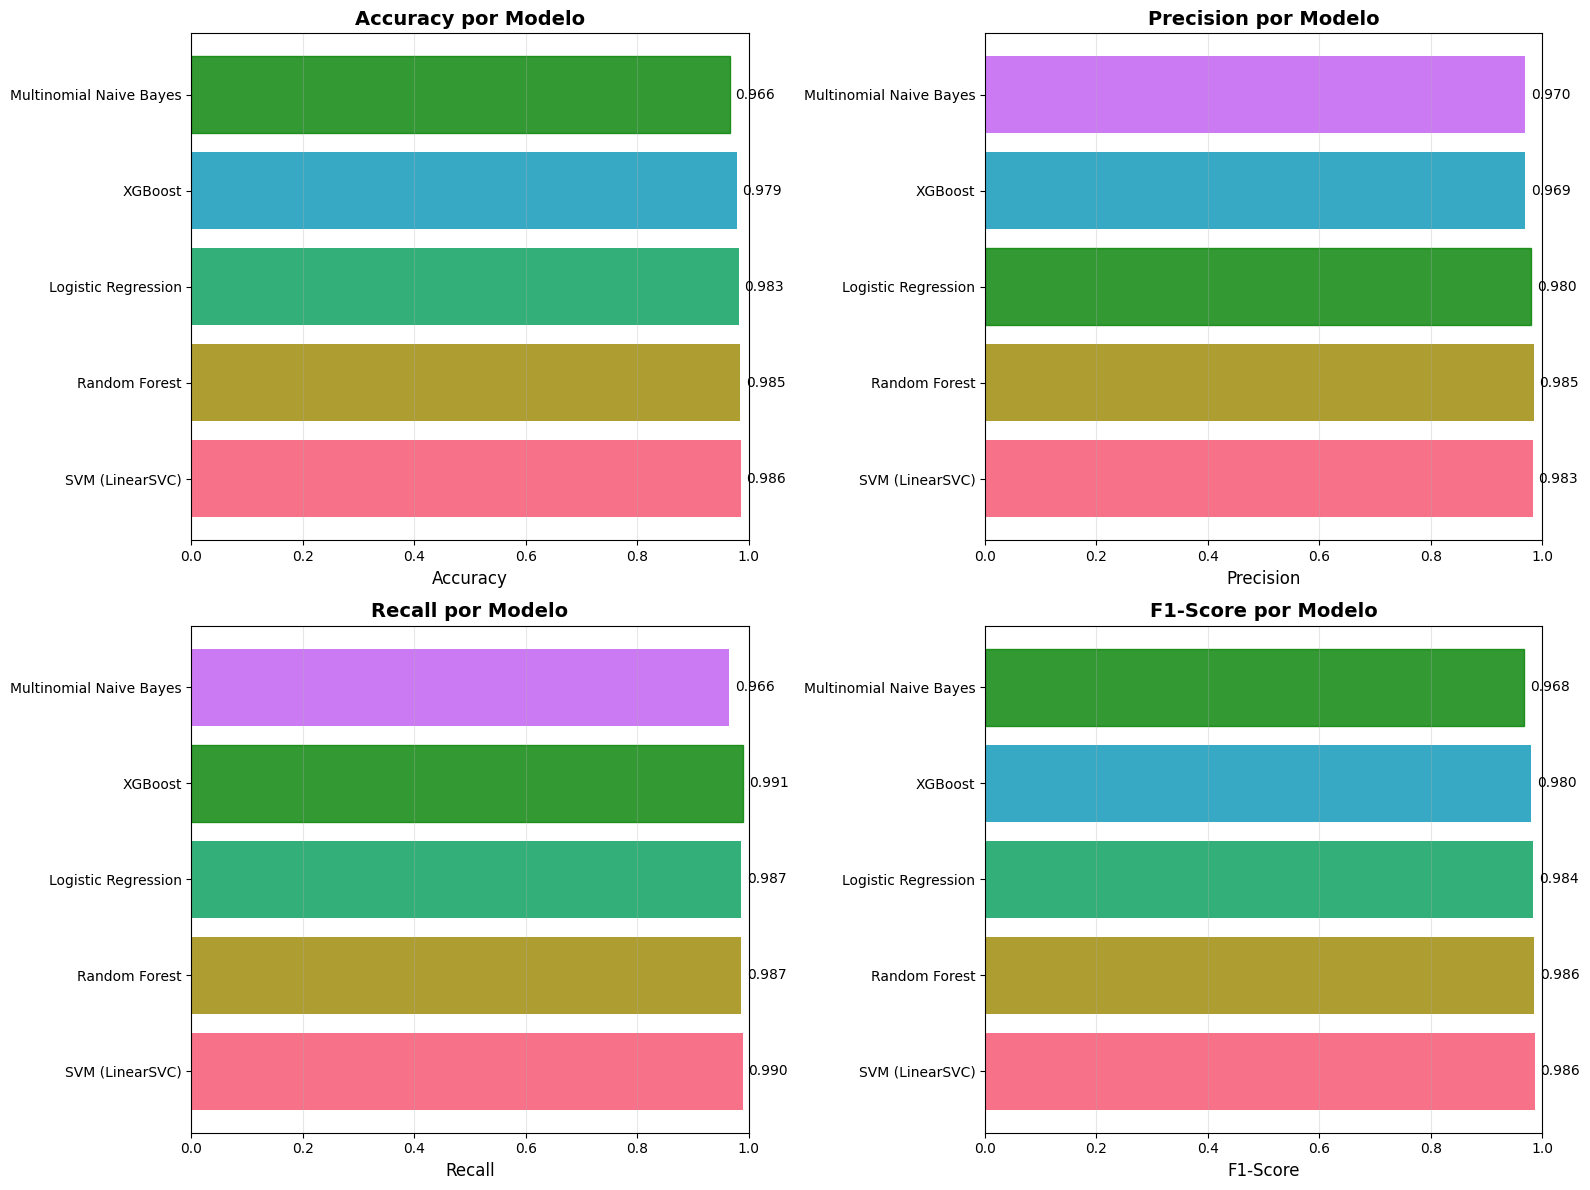

In [10]:
# Preparar dados para visualização
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
models_list = comparison_df['Model'].tolist()

# Criar gráfico de barras
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = comparison_df[metric].tolist()
    
    bars = ax.barh(models_list, values, color=sns.color_palette("husl", len(models_list)))
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} por Modelo', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=10)
    
    # Destacar melhor modelo
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_color('green')
    bars[best_idx].set_alpha(0.8)

plt.tight_layout()
plt.show()


## Passo 6: Análise Detalhada do Melhor Modelo

Visualizar matriz de confusão e relatório de classificação do melhor modelo.


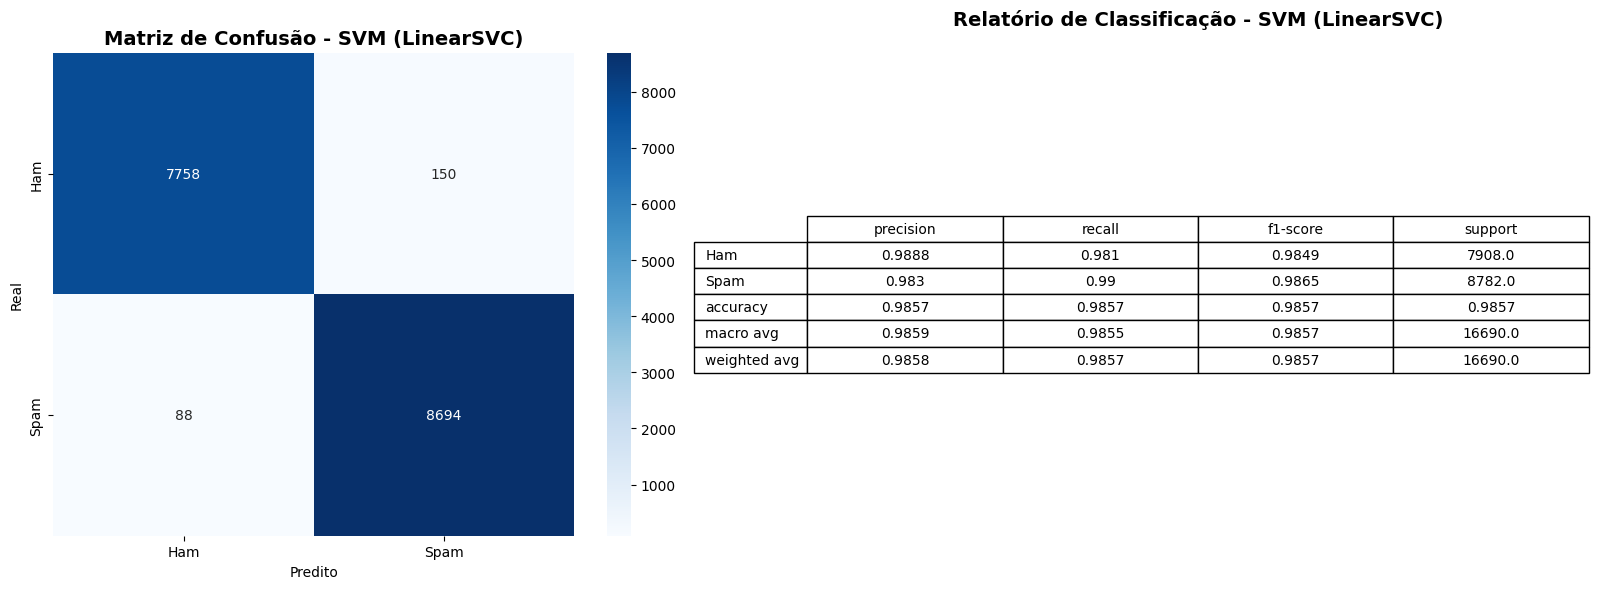


Relatório de Classificação - SVM (LinearSVC):
              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98      7908
        Spam       0.98      0.99      0.99      8782

    accuracy                           0.99     16690
   macro avg       0.99      0.99      0.99     16690
weighted avg       0.99      0.99      0.99     16690



In [11]:
# Obter melhor modelo
best_model = results[best_model_name]['model']
y_pred_best = best_model.predict(X_test_tfidf)

# XGBoost retorna labels numéricos, precisa converter de volta
if 'XGBoost' in best_model_name:
    y_pred_best = label_encoder.inverse_transform(y_pred_best)


# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_best, labels=['ham', 'spam'])

# Visualizar matriz de confusão
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
ax1.set_title(f'Matriz de Confusão - {best_model_name}', fontsize=14, fontweight='bold')
ax1.set_ylabel('Real')
ax1.set_xlabel('Predito')

# Relatório de classificação
report = classification_report(y_test, y_pred_best, 
                               target_names=['Ham', 'Spam'],
                               output_dict=True)

# Criar DataFrame do relatório
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

# Visualizar relatório
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=report_df.values,
                  rowLabels=report_df.index,
                  colLabels=report_df.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax2.set_title(f'Relatório de Classificação - {best_model_name}', 
              fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\nRelatório de Classificação - {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Ham', 'Spam']))


## Conclusão da Seleção de Modelos

### Melhor Modelo Selecionado

O melhor modelo foi identificado na tabela comparativa acima, baseado no F1-Score.

### Próximos Passos

**Notebook 03: Hyperparameter Tuning**
- Otimizar hiperparâmetros do melhor modelo
- Usar GridSearchCV ou RandomizedSearchCV
- Melhorar ainda mais a performance

**Notebook 04: Pipeline Final**
- Treinar modelo final com todos os dados
- Exportar modelo e vetorizador para produção
- Criar pipeline completo de inferência
